### Notebook criado para realizar a junção das bases de Meteorologia com Ocorrencias

In [1]:
from limpeza_padronizacao import *
from pipelines.pipeline_meteostat_diario import acessar_csv_s3
import pandas as pd
import matplotlib.pyplot as plt

### Obtendo os dados meteorológicos do S3

In [2]:
bucket_name = 'black-umbrella-fiap'
object_key = 'bronze/meteostat_diario/historico_diario_1950_2024.csv'

In [3]:
df_meteo = acessar_csv_s3(bucket_name, object_key)

In [4]:
df_meteo

,index,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Distrito,Latitude,Longitude
0,1950-01-01,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
1,1950-01-02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
2,1950-01-03,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
3,1950-01-04,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
4,1950-01-05,NaN,NaN,NaN,29.3,NaN,NaN,NaN,NaN,NaN,NaN,Água Rasa,-23.565372,-46.573697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559728,2024-09-11 00:00:00,25.4,19.6,31.3,0.0,NaN,115.0,7.9,NaN,1010.6,NaN,Vila Medeiros,-23.487707,-46.584496
2559729,2024-09-11 00:00:00,26.2,19.9,32.4,0.0,NaN,17.0,8.9,NaN,1010.5,NaN,Vila Prudente,-23.592335,-46.574961
2559730,2024-09-11 00:00:00,26.2,19.9,32.4,0.0,NaN,17.0,8.9,NaN,1010.5,NaN,Vila Sônia,-23.598656,-46.739294
2559731,2024-09-11 00:00:00,25.4,19.6,31.3,0.0,NaN,115.0,7.9,NaN,1010.6,NaN,São Domingos,-23.493876,-46.742194


In [5]:
dados_meteo = df_meteo.copy()

In [6]:
dados_meteo = dados_meteo.drop(columns=['snow', 'wpgt', 'tsun'])

In [7]:
# Padronizar nomes das colunas: remover espaços, substituir por sublinhados e converter para minúsculas
dados_meteo.columns = [unidecode.unidecode(col.strip().replace(' ', '_').lower()) for col in dados_meteo.columns]

# Remover coluna 'unnamed:_0' se existir
if 'unnamed:_0' in dados_meteo.columns:
    dados_meteo = dados_meteo.drop(columns=['unnamed:_0'])

# Normalizar texto em colunas de string: remover espaços em branco ao redor e padronizar para título
for col in dados_meteo.select_dtypes(include='object').columns:
    dados_meteo[col] = dados_meteo[col].str.strip().str.title()

# Remover acentuações dos dados de texto para padronização
dados_meteo = dados_meteo.applymap(lambda x: unidecode.unidecode(x) if isinstance(x, str) else x)

In [8]:
dados_meteo

,index,tavg,tmin,tmax,prcp,wdir,wspd,pres,distrito,latitude,longitude
0,1950-01-01,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
1,1950-01-02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
2,1950-01-03,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
3,1950-01-04,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
4,1950-01-05,NaN,NaN,NaN,29.3,NaN,NaN,NaN,Agua Rasa,-23.565372,-46.573697
...,...,...,...,...,...,...,...,...,...,...,...
2559728,2024-09-11 00:00:00,25.4,19.6,31.3,0.0,115.0,7.9,1010.6,Vila Medeiros,-23.487707,-46.584496
2559729,2024-09-11 00:00:00,26.2,19.9,32.4,0.0,17.0,8.9,1010.5,Vila Prudente,-23.592335,-46.574961
2559730,2024-09-11 00:00:00,26.2,19.9,32.4,0.0,17.0,8.9,1010.5,Vila Sonia,-23.598656,-46.739294
2559731,2024-09-11 00:00:00,25.4,19.6,31.3,0.0,115.0,7.9,1010.6,Sao Domingos,-23.493876,-46.742194


In [9]:
dados_meteo.dtypes

index         object
tavg         float64
tmin         float64
tmax         float64
prcp         float64
wdir         float64
wspd         float64
pres         float64
distrito      object
latitude     float64
longitude    float64
dtype: object

In [10]:
dados_meteo['prcp'].max()

301.0

### Obtendo os dados de ocorrências do S3

In [11]:
bucket_name = 'black-umbrella-fiap'
object_key = 'bronze/ocorrencias/ocorrencias_com_distritos.csv'

In [12]:
df_ocorr = acessar_csv_s3(bucket_name, object_key)

In [13]:
dados_ocorr = df_ocorr.copy()

In [14]:
# Padronizar nomes das colunas: remover espaços, substituir por sublinhados e converter para minúsculas
dados_ocorr.columns = [unidecode.unidecode(col.strip().replace(' ', '_').lower()) for col in dados_ocorr.columns]

# Remover coluna 'unnamed:_0' se existir
if 'unnamed:_0' in dados_ocorr.columns:
    dados_ocorr = dados_ocorr.drop(columns=['unnamed:_0'])

# Normalizar texto em colunas de string: remover espaços em branco ao redor e padronizar para título
for col in dados_ocorr.select_dtypes(include='object').columns:
    dados_ocorr[col] = dados_ocorr[col].str.strip().str.title()

# Remover acentuações dos dados de texto para padronização
dados_ocorr = dados_ocorr.applymap(lambda x: unidecode.unidecode(x) if isinstance(x, str) else x)

In [15]:
dados_ocorr

,data,ocorrencia,subprefeit,geometry,distrito,longitude,latitude
0,2013-12-29 00:00:00,Queda De Arvore,Bt - Butanta,Point Z (318923.7137000401 7389107.424428364 0),Raposo Tavares,-46.774643,-23.598443
1,2013-12-03 00:00:00,Queda De Arvore,Cs - Capela Do Socorro,Point Z (326291.0101464727 7378438.554415315 0),Socorro,-46.703712,-23.695577
2,2013-12-10 00:00:00,Alagamento,Sa - Santo Amaro,Point Z (325784.8790245799 7383070.030224832 0),Santo Amaro,-46.708130,-23.653706
3,2013-12-30 00:00:00,Queda De Arvore,Se - Se,Point Z (332913.13708172296 7396238.345912354 0),Republica,-46.636786,-23.535563
4,2013-12-29 00:00:00,Queda De Arvore,Sa - Santo Amaro,Point Z (325940.60835598 7385402.683087114 0),Santo Amaro,-46.706331,-23.632662
...,...,...,...,...,...,...,...
58147,2024-01-31 00:00:00,Alagamento,Sb - Sapopemba,Point (347483.63164646423 7386553.45190624),Sapopemba,-46.495083,-23.624450
58148,2024-01-31 00:00:00,Queda De Arvore,Iq - Itaquera,Point (354127.125688214 7394828.660900325),Jose Bonifacio,-46.429165,-23.550340
58149,2024-01-31 00:00:00,Inundacao,Cs - Capela Do Socorro,Point (328375.1026824678 7375680.958841767),Cidade Dutra,-46.683598,-23.720698
58150,2024-01-31 00:00:00,Queda De Arvore,Bt - Butanta,Point (324562.933228591 7390714.9646354485),Butanta,-46.719206,-23.584550


In [16]:
dados_ocorr.dtypes

data           object
ocorrencia     object
subprefeit     object
geometry       object
distrito       object
longitude     float64
latitude      float64
dtype: object

____

### Início Integração dos dados

___

## ACHO QUE AQUI VAI DAR BOM

- Utilizando a base DIÁRIA meteorológica

In [39]:
ocorrencias = dados_ocorr.copy()
meteorologia = dados_meteo.copy()

In [40]:
meteorologia = meteorologia.rename(columns={'index': 'data'})

In [41]:
meteorologia['data'] = pd.to_datetime(meteorologia['data'], format='mixed')  # ajuste conforme o nome da sua coluna de data
ocorrencias['data'] = pd.to_datetime(ocorrencias['data'], format='mixed')

In [42]:
# Realizar o merge com a base meteorológica
base_final = pd.merge(meteorologia, ocorrencias, how='outer', on=['data', 'distrito'])

In [43]:
base_final = base_final[base_final['data'].dt.year >= 2013]

In [45]:
base_final['ocorrencia'].notnull().sum()

58152

In [46]:
base_final

,data,tavg,tmin,tmax,prcp,wdir,wspd,pres,distrito,latitude_x,longitude_x,ocorrencia,subprefeit,geometry,longitude_y,latitude_y
2158165,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,NaN,Agua Rasa,-23.565372,-46.573697,NaN,NaN,NaN,NaN,NaN
2158166,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,NaN,Alto De Pinheiros,-23.549906,-46.707642,NaN,NaN,NaN,NaN,NaN
2158167,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,NaN,Anhanguera,-23.432908,-46.788534,NaN,NaN,NaN,NaN,NaN
2158168,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,NaN,Aricanduva,-23.578024,-46.511454,NaN,NaN,NaN,NaN,NaN
2158169,2013-01-01,29.6,20.0,31.0,NaN,315.0,11.1,NaN,Artur Alvim,-23.540469,-46.489791,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585094,2024-09-11,26.2,19.9,32.4,0.0,17.0,8.9,1010.5,Vila Mariana,-23.583700,-46.632741,NaN,NaN,NaN,NaN,NaN
2585095,2024-09-11,24.7,18.1,32.5,0.0,14.0,10.8,1015.3,Vila Matilde,-23.536179,-46.524605,NaN,NaN,NaN,NaN,NaN
2585096,2024-09-11,25.4,19.6,31.3,0.0,115.0,7.9,1010.6,Vila Medeiros,-23.487707,-46.584496,NaN,NaN,NaN,NaN,NaN
2585097,2024-09-11,26.2,19.9,32.4,0.0,17.0,8.9,1010.5,Vila Prudente,-23.592335,-46.574961,NaN,NaN,NaN,NaN,NaN


In [47]:
base_final = base_final.drop(columns=['subprefeit', 'geometry'])

In [48]:
base_final = base_final.rename(columns={'longitude_x': 'longitude_distrito', 'latitude_x': 'latitude_distrito', 'longitude_y': 'longitude_ocorrencia', 'latitude_y': 'latitude_ocorrencia'})

In [49]:
missings_por_coluna = base_final.isna().sum()
missings_por_coluna = pd.DataFrame(missings_por_coluna, columns=['n']).reset_index().rename(columns={'index': 'variaveis'})
missings_por_coluna

,variaveis,n
0,data,0
1,tavg,1724
2,tmin,10115
3,tmax,10479
4,prcp,145490
...,...,...
9,latitude_distrio,1072
10,longitude_distrito,1072
11,ocorrencia,368782
12,longitude_ocorrencia,368782


In [28]:
base_final.describe()

,data,tavg,tmin,tmax,prcp,wdir,wspd,pres,latitude_distrio,longitude_distrito,longitude_ocorrencia,latitude_ocorrencia
count,426934,425210.000000,416819.000000,416455.000000,281444.000000,394328.000000,415620.000000,304495.000000,425862.000000,425862.000000,58152.000000,58152.000000
mean,2018-11-04 14:39:51.882586112,21.376335,16.672455,25.813262,3.907951,147.540514,11.062086,1017.506038,-23.557420,-46.605025,-46.623979,-23.570176
min,2013-01-01 00:00:00,7.100000,1.000000,8.000000,0.000000,0.000000,0.000000,894.900000,-23.908391,-46.788534,-46.823152,-23.937753
25%,2015-12-28 00:00:00,18.700000,14.500000,23.000000,0.000000,87.000000,8.500000,1014.700000,-23.596499,-46.701939,-46.703231,-23.613980
50%,2018-11-14 00:00:00,21.500000,17.000000,26.000000,0.000000,126.000000,10.800000,1017.400000,-23.551530,-46.638164,-46.651913,-23.565046
75%,2021-09-30 00:00:00,24.100000,19.000000,29.000000,3.000000,172.000000,13.500000,1020.400000,-23.510151,-46.537791,-46.563061,-23.513567
max,2024-09-11 00:00:00,36.300000,25.900000,39.000000,189.000000,360.000000,31.600000,1032.000000,-22.957140,-45.547526,-46.365454,-23.373848
std,NaN,3.920716,3.320055,4.358377,9.676696,97.574948,3.892479,5.275863,0.100396,0.153787,0.107951,0.075200


In [50]:
base_final['prcp'] = base_final['prcp'].fillna(0)
base_final['wdir'] = base_final['wdir'].fillna(base_final['wdir'].mean())
base_final['wspd'] = base_final['wspd'].fillna(base_final['wspd'].mean())
base_final['tavg'] = base_final['tavg'].fillna(base_final['tavg'].mean())
base_final['tmin'] = base_final['tmin'].fillna(base_final['tmin'].mean())
base_final['tmax'] = base_final['tmax'].fillna(base_final['tmax'].mean())
base_final['pres'] = base_final['pres'].fillna(base_final['pres'].mean())

In [51]:
base_final

,data,tavg,tmin,tmax,prcp,wdir,wspd,pres,distrito,latitude_distrio,longitude_distrito,ocorrencia,longitude_ocorrencia,latitude_ocorrencia
2158165,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.506038,Agua Rasa,-23.565372,-46.573697,NaN,NaN,NaN
2158166,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.506038,Alto De Pinheiros,-23.549906,-46.707642,NaN,NaN,NaN
2158167,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.506038,Anhanguera,-23.432908,-46.788534,NaN,NaN,NaN
2158168,2013-01-01,25.5,21.9,31.0,0.0,316.0,16.8,1017.506038,Aricanduva,-23.578024,-46.511454,NaN,NaN,NaN
2158169,2013-01-01,29.6,20.0,31.0,0.0,315.0,11.1,1017.506038,Artur Alvim,-23.540469,-46.489791,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585094,2024-09-11,26.2,19.9,32.4,0.0,17.0,8.9,1010.500000,Vila Mariana,-23.583700,-46.632741,NaN,NaN,NaN
2585095,2024-09-11,24.7,18.1,32.5,0.0,14.0,10.8,1015.300000,Vila Matilde,-23.536179,-46.524605,NaN,NaN,NaN
2585096,2024-09-11,25.4,19.6,31.3,0.0,115.0,7.9,1010.600000,Vila Medeiros,-23.487707,-46.584496,NaN,NaN,NaN
2585097,2024-09-11,26.2,19.9,32.4,0.0,17.0,8.9,1010.500000,Vila Prudente,-23.592335,-46.574961,NaN,NaN,NaN


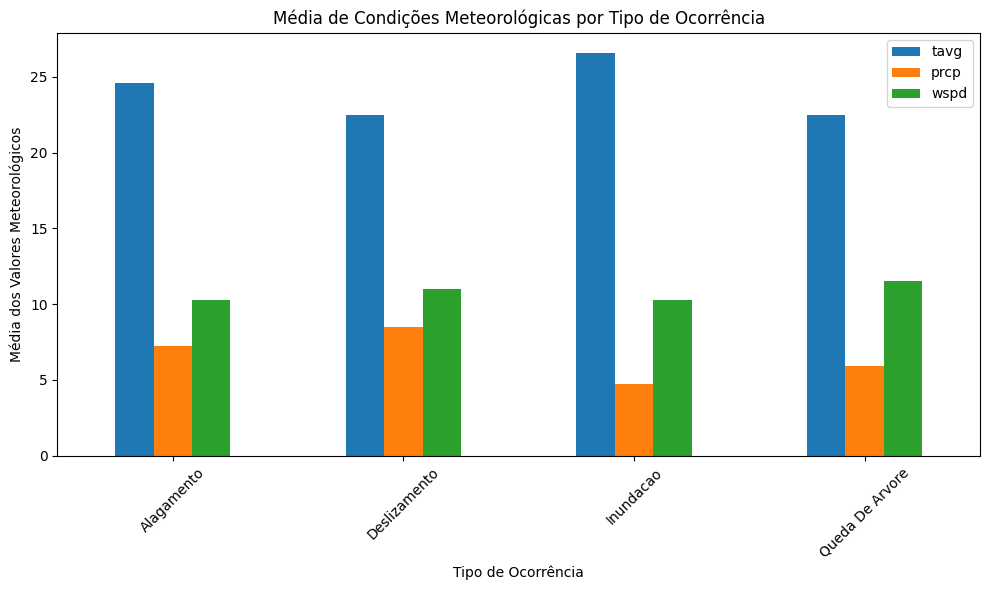

In [52]:
# Selecionando as colunas meteorológicas numéricas
colunas_meteorologicas = ['tavg', 'prcp', 'wspd']

# Removendo linhas com todas as colunas meteorológicas NaN
ocorrencias_clean = base_final.dropna(subset=colunas_meteorologicas, how='all')

# Agrupando por tipo de ocorrência e calculando a média das colunas meteorológicas
ocorrencias_meteorologicas = ocorrencias_clean.groupby('ocorrencia')[colunas_meteorologicas].mean()

# Plotando um gráfico de barras
ocorrencias_meteorologicas.plot(kind='bar', figsize=(10,6))
plt.title('Média de Condições Meteorológicas por Tipo de Ocorrência')
plt.ylabel('Média dos Valores Meteorológicos')
plt.xlabel('Tipo de Ocorrência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analisando Quedas de Arvores

In [61]:
base_arvores = base_final[base_final['ocorrencia'] == 'Queda De Arvore']

In [62]:
base_arvores = base_arvores[base_arvores['data'].dt.year == 2023]

In [63]:
base_arvores = base_arvores.head(500)

In [64]:
base_arvores

,data,tavg,tmin,tmax,prcp,wdir,wspd,pres,distrito,latitude_distrio,longitude_distrito,ocorrencia,longitude_ocorrencia,latitude_ocorrencia
2523154,2023-01-01,22.1,18.7,27.5,7.9,91.0,10.5,1018.0,Campo Belo,-23.629934,-46.670417,Queda De Arvore,-46.675552,-23.614407
2523163,2023-01-01,24.5,16.8,25.9,2.9,58.0,6.0,1015.6,Cidade Lider,-23.562770,-46.494333,Queda De Arvore,-46.504657,-23.550975
2523164,2023-01-01,24.5,16.8,25.9,2.9,58.0,6.0,1015.6,Cidade Lider,-23.562770,-46.494333,Queda De Arvore,-46.504657,-23.550975
2523205,2023-01-01,22.1,18.7,27.5,7.9,91.0,10.5,1018.0,Raposo Tavares,-23.591709,-46.780512,Queda De Arvore,-46.772115,-23.590464
2523225,2023-01-01,20.5,17.1,26.0,4.8,80.0,5.7,1015.6,Vila Formosa,-23.566876,-46.546323,Queda De Arvore,-46.535379,-23.574257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526865,2023-02-06,22.8,20.6,27.0,5.1,343.0,10.9,1016.7,Cidade Dutra,-23.713964,-46.699088,Queda De Arvore,-46.708691,-23.729688
2526878,2023-02-06,25.7,18.6,27.1,24.4,308.0,10.9,1014.2,Itaquera,-23.536080,-46.455510,Queda De Arvore,-46.457899,-23.525249
2526888,2023-02-06,22.8,20.6,27.0,5.1,343.0,10.9,1016.7,Jardim Sao Luis,-23.673927,-46.740738,Queda De Arvore,-46.753309,-23.697605
2526914,2023-02-06,22.8,20.6,27.0,5.1,343.0,10.9,1016.7,Santo Amaro,-23.655655,-46.720973,Queda De Arvore,-46.693293,-23.655195


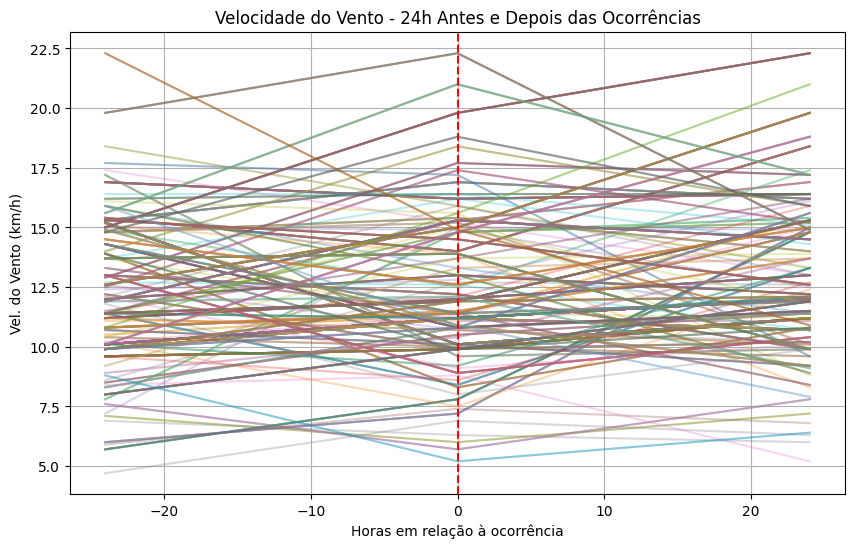

In [74]:
# Filtra as ocorrências
df_ocorrencias = base_arvores.dropna(subset=['ocorrencia'])

# Lista para armazenar os dados de temperatura relativos
tempos_relativos = []
temperaturas = []

# Para cada ocorrência
for _, row in df_ocorrencias.iterrows():
    data_ocorrencia = row['data']
    distrito = row['distrito']
    
    # Filtrar os dados 24 horas antes e depois da ocorrência
    mask = (base_final['data'] >= (data_ocorrencia - pd.Timedelta(hours=24))) & \
           (base_final['data'] <= (data_ocorrencia + pd.Timedelta(hours=24))) & \
           (base_final['distrito'] == distrito)
    temp_data = base_final.loc[mask]
    
    # Ajustar o tempo relativo ao ponto de ocorrência (0)
    temp_data['tempo_relativo'] = (temp_data['data'] - data_ocorrencia).dt.total_seconds() / 3600
    
    # Adiciona os dados à lista
    tempos_relativos.append(temp_data['tempo_relativo'])
    temperaturas.append(temp_data['wspd'])  # Você pode também usar tmin ou tmax

# Plotar todas as curvas sobrepostas
plt.figure(figsize=(10, 6))

for i in range(len(tempos_relativos)):
    plt.plot(tempos_relativos[i], temperaturas[i], alpha=0.3)  # alpha para sobreposição

plt.title('Velocidade do Vento - 24h Antes e Depois das Ocorrências')
plt.xlabel('Horas em relação à ocorrência')
plt.ylabel('Vel. do Vento (km/h)')
plt.axvline(x=0, color='red', linestyle='--')  # Linha vertical no momento da ocorrência
plt.grid(True)
plt.show()

### Analisando Alagamentos

In [67]:
base_alagamentos = base_final[base_final['ocorrencia'] == 'Alagamento']

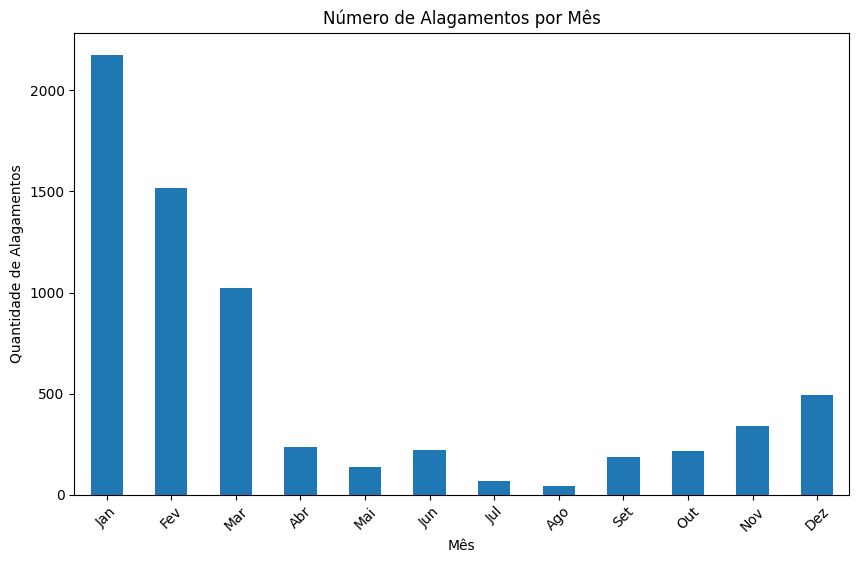

In [73]:
# Agrupar os dados por mês e contar a quantidade de ocorrências
ocorrencias_por_mes = base_alagamentos.groupby(base_alagamentos['data'].dt.month)['ocorrencia'].count()
# Plotar o gráfico de barras
ocorrencias_por_mes.plot(kind='bar', figsize=(10, 6))
plt.title('Número de Alagamentos por Mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Alagamentos')
plt.xticks(range(12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)
plt.show()

- Utilizando a base com HORÁRIOS meteorológicos

In [75]:
ocorrencias_teste = pd.read_csv('dados/ocorrencias_com_distritos_teste.csv', sep=';')

In [76]:
ocorrencias_teste

,data,ocorrencia,subprefeit,geometry,distrito,Longitude,Latitude
0,29/12/2013 00:00,QUEDA DE ARVORE,BT - BUTANTA,POINT Z (318923.7137000401 7389107.424428364 0),RAPOSO TAVARES,-46.774643,-23.598443
1,03/12/2013 00:00,QUEDA DE ARVORE,CS - CAPELA DO SOCORRO,POINT Z (326291.0101464727 7378438.554415315 0),SOCORRO,-46.703712,-23.695577
2,10/12/2013 00:00,ALAGAMENTO,SA - SANTO AMARO,POINT Z (325784.8790245799 7383070.030224832 0),SANTO AMARO,-46.708130,-23.653706
3,30/12/2013 00:00,QUEDA DE ARVORE,SE - SE,POINT Z (332913.13708172296 7396238.345912354 0),REPUBLICA,-46.636786,-23.535563
4,29/12/2013 00:00,QUEDA DE ARVORE,SA - SANTO AMARO,POINT Z (325940.60835598 7385402.683087114 0),SANTO AMARO,-46.706331,-23.632662
...,...,...,...,...,...,...,...
58147,31/01/2024 00:00,ALAGAMENTO,SB - SAPOPEMBA,POINT (347483.63164646423 7386553.45190624),SAPOPEMBA,-46.495083,-23.624450
58148,31/01/2024 00:00,QUEDA DE ARVORE,IQ - ITAQUERA,POINT (354127.125688214 7394828.660900325),JOSE BONIFACIO,-46.429165,-23.550340
58149,31/01/2024 00:00,INUNDACAO,CS - CAPELA DO SOCORRO,POINT (328375.1026824678 7375680.958841767),CIDADE DUTRA,-46.683598,-23.720698
58150,31/01/2024 00:00,QUEDA DE ARVORE,BT - BUTANTA,POINT (324562.933228591 7390714.9646354485),BUTANTA,-46.719206,-23.584550


In [77]:
ocorrencias_teste['data'] = pd.to_datetime(ocorrencias_teste['data'], format='mixed')

In [78]:
bucket_name = 'black-umbrella-fiap'
object_key = 'bronze/meteostat_horario/horario_2020_2024.csv'
df_horario = acessar_csv_s3(bucket_name, object_key)

In [96]:
df_horario

,data,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,distrito,latitude,longitude
0,2020-01-01 00:00:00,23.9,19.6,77.0,NaN,130.0,3.6,1013.0,2.0,Agua Rasa,-23.565372,-46.573697
1,2020-01-01 01:00:00,24.0,19.1,74.0,NaN,80.0,7.6,1014.0,2.0,Agua Rasa,-23.565372,-46.573697
2,2020-01-01 02:00:00,24.0,19.1,74.0,NaN,60.0,9.4,1014.0,1.0,Agua Rasa,-23.565372,-46.573697
3,2020-01-01 03:00:00,24.0,18.0,69.0,NaN,40.0,5.4,1013.0,2.0,Agua Rasa,-23.565372,-46.573697
4,2020-01-01 04:00:00,24.0,18.0,69.0,NaN,50.0,5.4,1013.0,1.0,Agua Rasa,-23.565372,-46.573697
...,...,...,...,...,...,...,...,...,...,...,...,...
3869128,2024-09-11 20:00:00,30.5,5.0,20.0,0.0,24.0,13.3,1012.9,3.0,Lajeado,-23.536248,-46.410022
3869129,2024-09-11 21:00:00,27.2,7.6,29.0,0.0,61.0,11.9,1013.5,3.0,Lajeado,-23.536248,-46.410022
3869130,2024-09-11 22:00:00,25.1,7.7,33.0,0.0,40.0,11.2,1014.3,2.0,Lajeado,-23.536248,-46.410022
3869131,2024-09-11 23:00:00,24.0,7.2,34.0,0.0,13.0,10.4,1015.1,3.0,Lajeado,-23.536248,-46.410022


In [80]:
df_horario = df_horario.drop(columns=['snow', 'wpgt', 'tsun'])

In [81]:
df_horario = df_horario.rename(columns={'index': 'data'})

In [82]:
df_horario['data'] = pd.to_datetime(df_horario['data'])

In [84]:
df_horario.dtypes

data         datetime64[ns]
temp                float64
dwpt                float64
rhum                float64
prcp                float64
                  ...      
pres                float64
coco                float64
Distrito             object
Latitude            float64
Longitude           float64
Length: 12, dtype: object

In [87]:
df_ocorrencias = pd.read_csv('dados/ocorrencias_com_distritos_teste.csv', sep=';')

In [91]:
df_ocorrencias['data'] = pd.to_datetime(df_ocorrencias['data'], format='mixed')

In [104]:
teste

,data,ocorrencia,subprefeit,geometry,distrito,longitude,latitude
36436,2020-01-01,Queda De Arvore,Jt - Jacana/Tremembe,Point (335276.4972016554 7404962.340116704),Tremembe,-46.612683,-23.457033
36437,2020-01-01,Queda De Arvore,La - Lapa,Point (327366.92151131725 7396220.971177989),Perdizes,-46.691101,-23.535139
36438,2020-01-01,Queda De Arvore,Iq - Itaquera,Point (353498.93641415983 7396143.408035017),Jose Bonifacio,-46.435189,-23.538411
36439,2020-01-01,Queda De Arvore,Mb - M Boi Mirim,Point (318166.43002944475 7373735.167592265),Jardim Angela,-46.783945,-23.737143
36440,2020-01-01,Queda De Arvore,Mo - Mooca,Point (336433.12054204 7393809.882504777),Mooca,-46.602581,-23.557849
...,...,...,...,...,...,...,...
58147,2024-01-31,Alagamento,Sb - Sapopemba,Point (347483.63164646423 7386553.45190624),Sapopemba,-46.495083,-23.624450
58148,2024-01-31,Queda De Arvore,Iq - Itaquera,Point (354127.125688214 7394828.660900325),Jose Bonifacio,-46.429165,-23.550340
58149,2024-01-31,Inundacao,Cs - Capela Do Socorro,Point (328375.1026824678 7375680.958841767),Cidade Dutra,-46.683598,-23.720698
58150,2024-01-31,Queda De Arvore,Bt - Butanta,Point (324562.933228591 7390714.9646354485),Butanta,-46.719206,-23.584550


In [114]:
df_ocorrencias

,data,ocorrencia,subprefeit,geometry,distrito,longitude,latitude
0,2013-12-29,Queda De Arvore,Bt - Butanta,Point Z (318923.7137000401 7389107.424428364 0),Raposo Tavares,-46.774643,-23.598443
1,2013-03-12,Queda De Arvore,Cs - Capela Do Socorro,Point Z (326291.0101464727 7378438.554415315 0),Socorro,-46.703712,-23.695577
2,2013-10-12,Alagamento,Sa - Santo Amaro,Point Z (325784.8790245799 7383070.030224832 0),Santo Amaro,-46.708130,-23.653706
3,2013-12-30,Queda De Arvore,Se - Se,Point Z (332913.13708172296 7396238.345912354 0),Republica,-46.636786,-23.535563
4,2013-12-29,Queda De Arvore,Sa - Santo Amaro,Point Z (325940.60835598 7385402.683087114 0),Santo Amaro,-46.706331,-23.632662
...,...,...,...,...,...,...,...
58147,2024-01-31,Alagamento,Sb - Sapopemba,Point (347483.63164646423 7386553.45190624),Sapopemba,-46.495083,-23.624450
58148,2024-01-31,Queda De Arvore,Iq - Itaquera,Point (354127.125688214 7394828.660900325),Jose Bonifacio,-46.429165,-23.550340
58149,2024-01-31,Inundacao,Cs - Capela Do Socorro,Point (328375.1026824678 7375680.958841767),Cidade Dutra,-46.683598,-23.720698
58150,2024-01-31,Queda De Arvore,Bt - Butanta,Point (324562.933228591 7390714.9646354485),Butanta,-46.719206,-23.584550


In [132]:
df_merged = pd.merge(df_horario, teste, on=['data', 'distrito'], how='left')

In [127]:
df_merged['ocorrencia'].notnull().sum()

20957

In [133]:
df_merged = df_merged[df_merged['data'].dt.year >= 2020]

In [134]:
df_merged = df_merged.drop(columns=['subprefeit', 'geometry'])

In [135]:
df_merged

,data,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,distrito,latitude_x,longitude_x,ocorrencia,longitude_y,latitude_y
0,2020-01-01 00:00:00,23.9,19.6,77.0,NaN,130.0,3.6,1013.0,2.0,Agua Rasa,-23.565372,-46.573697,NaN,NaN,NaN
1,2020-01-01 01:00:00,24.0,19.1,74.0,NaN,80.0,7.6,1014.0,2.0,Agua Rasa,-23.565372,-46.573697,NaN,NaN,NaN
2,2020-01-01 02:00:00,24.0,19.1,74.0,NaN,60.0,9.4,1014.0,1.0,Agua Rasa,-23.565372,-46.573697,NaN,NaN,NaN
3,2020-01-01 03:00:00,24.0,18.0,69.0,NaN,40.0,5.4,1013.0,2.0,Agua Rasa,-23.565372,-46.573697,NaN,NaN,NaN
4,2020-01-01 04:00:00,24.0,18.0,69.0,NaN,50.0,5.4,1013.0,1.0,Agua Rasa,-23.565372,-46.573697,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876875,2024-09-11 20:00:00,30.5,5.0,20.0,0.0,24.0,13.3,1012.9,3.0,Lajeado,-23.536248,-46.410022,NaN,NaN,NaN
3876876,2024-09-11 21:00:00,27.2,7.6,29.0,0.0,61.0,11.9,1013.5,3.0,Lajeado,-23.536248,-46.410022,NaN,NaN,NaN
3876877,2024-09-11 22:00:00,25.1,7.7,33.0,0.0,40.0,11.2,1014.3,2.0,Lajeado,-23.536248,-46.410022,NaN,NaN,NaN
3876878,2024-09-11 23:00:00,24.0,7.2,34.0,0.0,13.0,10.4,1015.1,3.0,Lajeado,-23.536248,-46.410022,NaN,NaN,NaN


In [136]:
# PEGANDO SÓ ALAGAMENTOS NA BASE
df_alag = df_merged[df_merged['ocorrencia'] == 'Alagamento']

In [138]:
df_alag = df_alag[df_alag['data'].dt.year == 2023]

In [141]:
df_alag2 = df_alag.head(50)

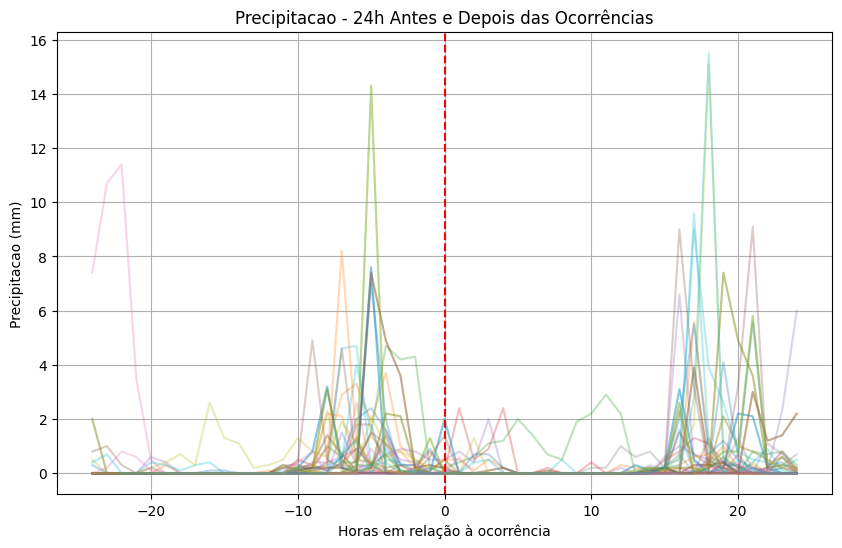

In [143]:
# Filtra as ocorrências
df_ocorrencias = df_alag2.dropna(subset=['ocorrencia'])

# Lista para armazenar os dados de temperatura relativos
tempos_relativos = []
temperaturas = []

# Para cada ocorrência
for _, row in df_alag2.iterrows():
    data_ocorrencia = row['data']
    distrito = row['distrito']
    
    # Filtrar os dados 24 horas antes e depois da ocorrência
    mask = (df_merged['data'] >= (data_ocorrencia - pd.Timedelta(hours=24))) & \
           (df_merged['data'] <= (data_ocorrencia + pd.Timedelta(hours=24))) & \
           (df_merged['distrito'] == distrito)
    temp_data = df_merged.loc[mask]
    
    # Ajustar o tempo relativo ao ponto de ocorrência (0)
    temp_data['tempo_relativo'] = (temp_data['data'] - data_ocorrencia).dt.total_seconds() / 3600
    
    # Adiciona os dados à lista
    tempos_relativos.append(temp_data['tempo_relativo'])
    temperaturas.append(temp_data['prcp'])  # Você pode também usar tmin ou tmax

# Plotar todas as curvas sobrepostas
plt.figure(figsize=(10, 6))

for i in range(len(tempos_relativos)):
    plt.plot(tempos_relativos[i], temperaturas[i], alpha=0.3)  # alpha para sobreposição

plt.title('Precipitacao - 24h Antes e Depois das Ocorrências')
plt.xlabel('Horas em relação à ocorrência')
plt.ylabel('Precipitacao (mm)')
plt.axvline(x=0, color='red', linestyle='--')  # Linha vertical no momento da ocorrência
plt.grid(True)
plt.show()